In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange


params = {'text.usetex': False,
          'mathtext.fontset': 'stix',
            'axes.titlesize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 8,
            'legend.numpoints': 3,
            'legend.fancybox': False,
            'legend.edgecolor': 'k'}
plt.rcParams.update(params)

In [2]:
x = np.arange(5)
cell_interfaces = np.append((x-0.5), x[-1]+0.5)
cell_names = ['$x_{i-2}$', '$x_{i-1}$', '$x_{i}$', '$x_{i+1}$', '$x_{i+2}$']


s = np.array([88, 110, 3, 16, 14])
# s = s/np.linalg.norm(s)


In [3]:
def recon(x, s):

    n = len(s)
    dx = x[1]-x[0]

    integrated = np.zeros((n,n))
    for i, xi in enumerate(x):
        _intg = [ ((xi+dx/2)**(n-k) - (xi-dx/2)**(n-k))/(n-k) for k in range(n)]
        integrated[i,:] = _intg/dx
    
    coef = np.linalg.solve(integrated, s)
    return np.poly1d(coef)

In [4]:
def weno_betas(s):

    i = 2
    beta = np.zeros(3)

    beta[0] = 13./12.*(s[i-2] - 2.*s[i-1] + s[i  ] )**2 + 0.25*(   s[i-2] - 4.*s[i-1] + 3.*s[i  ] )**2
    beta[1] = 13./12.*(s[i-1] - 2.*s[i  ] + s[i+1] )**2 + 0.25*(   s[i-1]             -    s[i+1] )**2
    beta[2] = 13./12.*(s[i  ] - 2.*s[i+1] + s[i+2] )**2 + 0.25*(3.*s[i  ] - 4.*s[i+1] +    s[i+2] )**2
    
    return beta

In [5]:
def nonlin_weights(s, direction):

    lin_w = np.array([.3, .6, .1])
    beta = weno_betas(s)
    
    if direction == 'imh':
        lin_w = np.array([.3, .6, .1])
    elif direction == 'iph':
        lin_w = np.array([.1, .6, .3])
    else:
        raise KeyError(direction)
    
    nonlin_w = lin_w/(1.E-36 + beta)**2
    
    return nonlin_w/np.linalg.norm(nonlin_w)

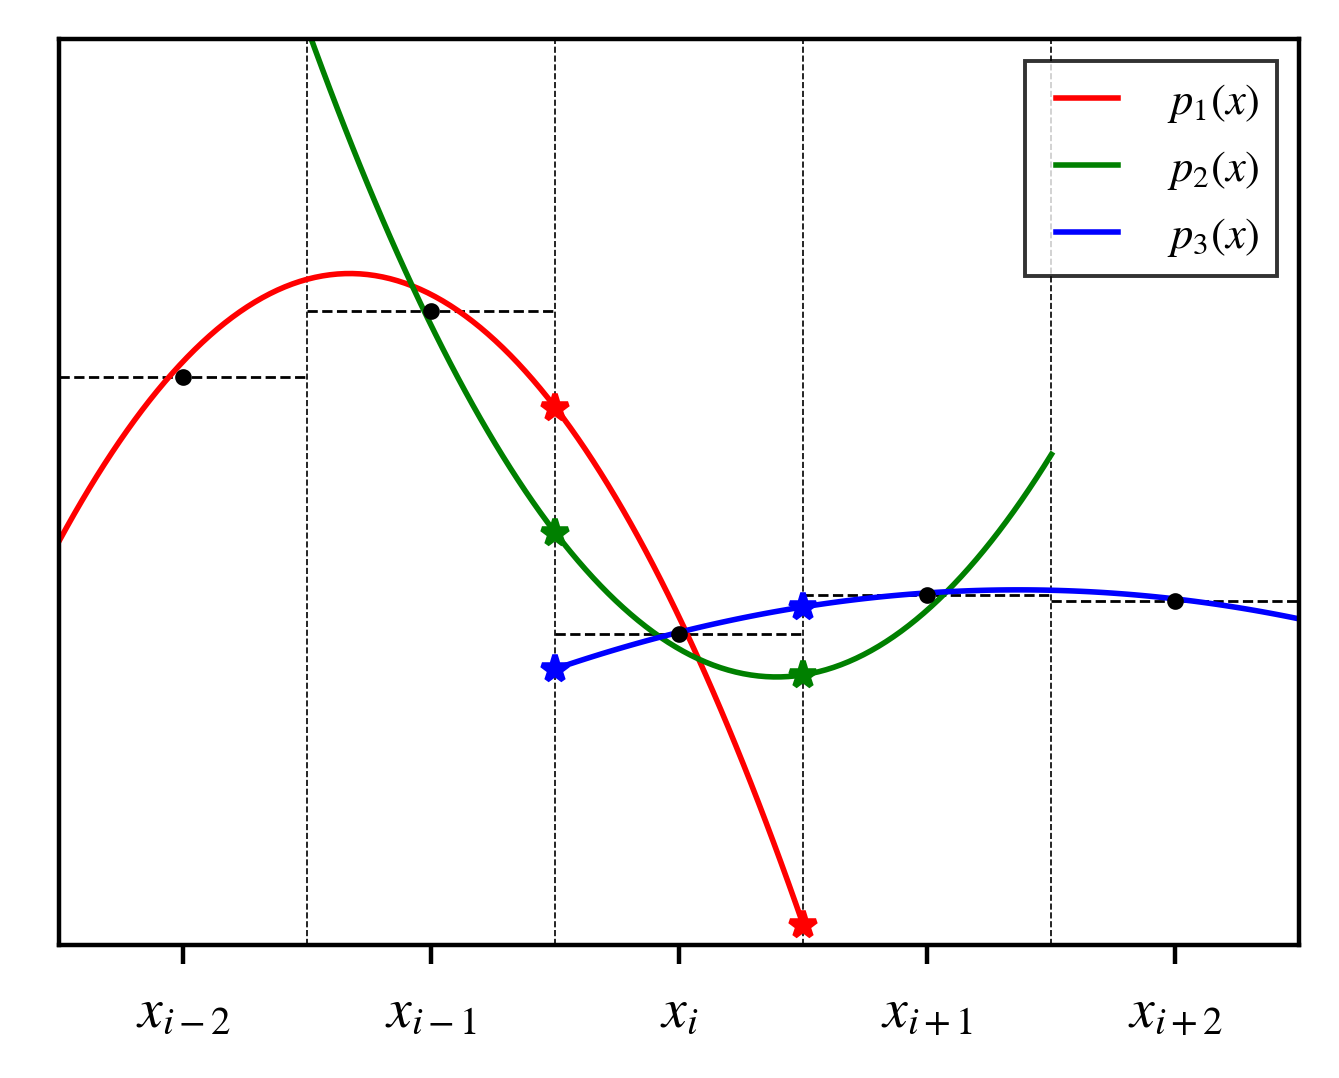

In [6]:
fig = plt.figure(figsize=(4,3), dpi=400)
ax = fig.add_subplot(1,1,1)

# vertical lines at cell interfaces
for interface in cell_interfaces:
    ax.axvline(x=interface, color='k', linestyle='--', linewidth=0.3)

# horizontal lines at cell centers
for idx, point in enumerate(s):
    ax.axhline(point, xmin=idx*0.2, xmax=(idx+1)*0.2, color='k', linestyle='--', linewidth=0.5)

ax.set_xlim((cell_interfaces[0], cell_interfaces[-1]))
ax.set_xticks(x)
ax.set_xticklabels(cell_names)

ax.set_ylim((-100,200))

ax.set_yticks([])


ximh = cell_interfaces[2]
xiph = cell_interfaces[3]

# reconstructions

# phi
# poly = recon(x, s)
# xx = np.linspace(cell_interfaces[0], cell_interfaces[-1], 100)
# ax.plot(xx, poly(xx), 'm-', linewidth=1, label='$\phi(x)$')
# ax.plot(ximh, poly(ximh), 'm*', markersize=5)

#p1
poly1 = recon(x[:3], s[:3])
xx = np.linspace(cell_interfaces[0], cell_interfaces[3], 100)
ax.plot(xx, poly1(xx), 'r-', linewidth=1, label='$p_{1}(x)$')
ax.plot(ximh, poly1(ximh), 'r*', markersize=5)
ax.plot(xiph, poly1(xiph), 'r*', markersize=5)

#p2
poly2 = recon(x[1:4], s[1:4])
xx = np.linspace(cell_interfaces[1], cell_interfaces[4], 100)
ax.plot(xx, poly2(xx), 'g-', linewidth=1, label='$p_{2}(x)$')
ax.plot(ximh, poly2(ximh), 'g*', markersize=5)
ax.plot(xiph, poly2(xiph), 'g*', markersize=5)
#p3
poly3 = recon(x[2:], s[2:])
xx = np.linspace(cell_interfaces[2], cell_interfaces[-1], 100)
ax.plot(xx, poly3(xx), 'b-', linewidth=1, label='$p_{3}(x)$')
ax.plot(ximh, poly3(ximh), 'b*', markersize=5)
ax.plot(xiph, poly3(xiph), 'b*', markersize=5)

ax.plot(x, s, 'ko', markersize=2)

legend = ax.legend(loc='upper right')
legend.get_frame().set_linewidth(.7)

# fig.savefig('weno_p1p2p3.pdf', bbox_inches='tight', pad_inches=0.05)

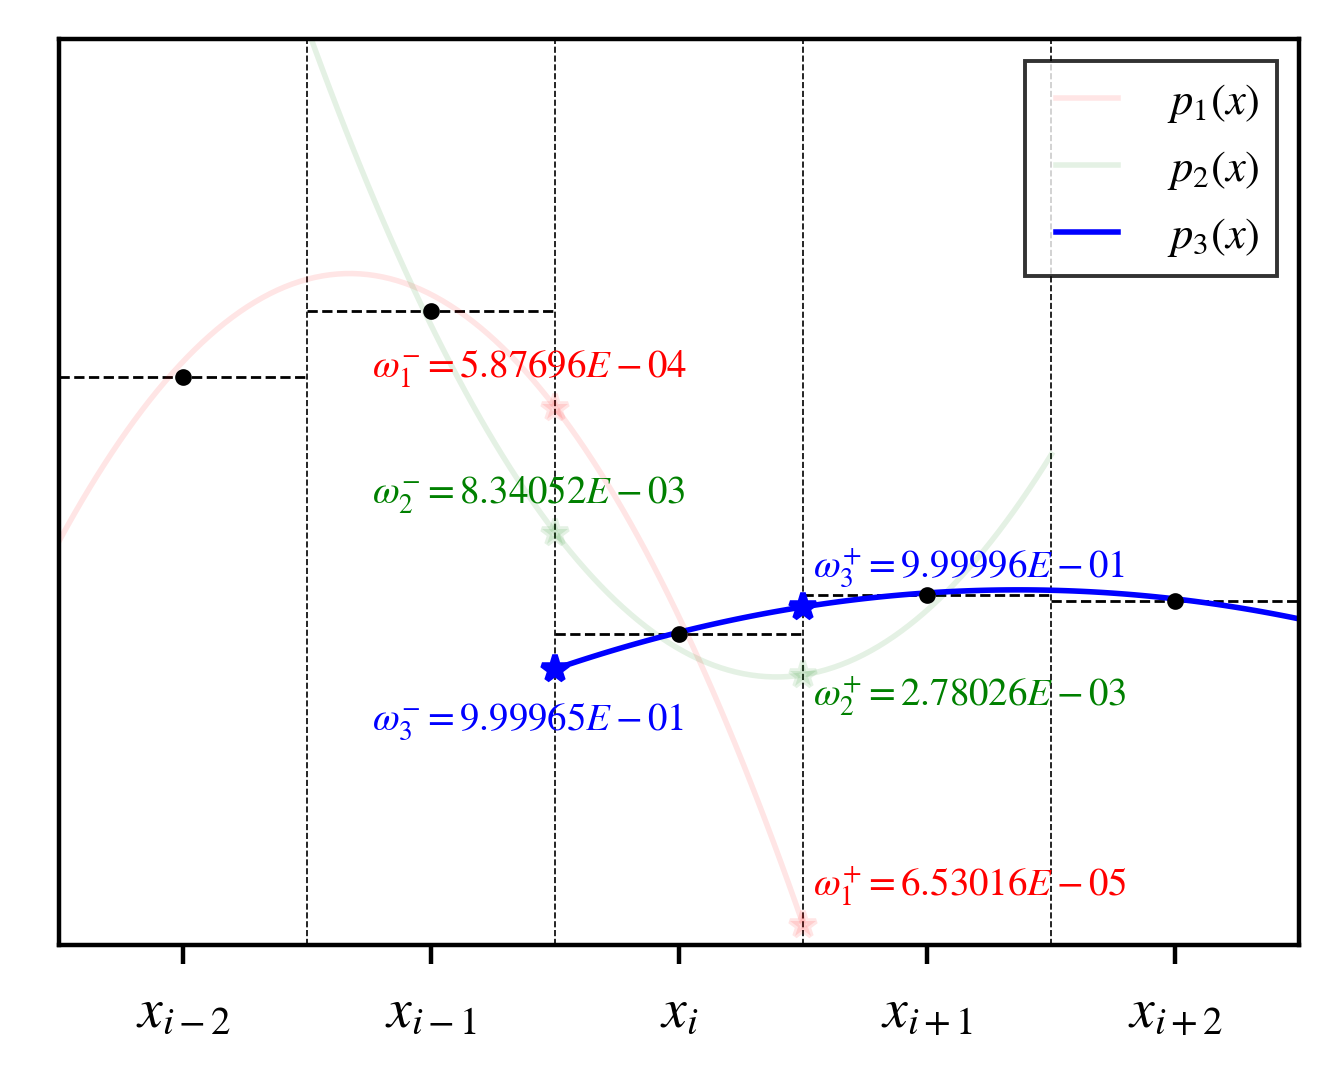

In [7]:
fig = plt.figure(figsize=(4,3), dpi=400)
ax = fig.add_subplot(1,1,1)

# vertical lines at cell interfaces
for interface in cell_interfaces:
    ax.axvline(x=interface, color='k', linestyle='--', linewidth=0.3)

# horizontal lines at cell centers
for idx, point in enumerate(s):
    ax.axhline(point, xmin=idx*0.2, xmax=(idx+1)*0.2, color='k', linestyle='--', linewidth=0.5)

ax.set_xlim((cell_interfaces[0], cell_interfaces[-1]))
ax.set_xticks(x)
ax.set_xticklabels(cell_names)

# ax.set_ylim((0,s.max()*1.4))

ax.set_ylim((-100,200))

ax.set_yticks([])


ximh = cell_interfaces[2]
xiph = cell_interfaces[3]

# reconstructions
omega_imh = nonlin_weights(s, 'imh')
omega_iph = nonlin_weights(s, 'iph')

opac_imh = 0.1 + 0.9*omega_imh
opac_iph = 0.1 + 0.9*omega_iph

# phi
# poly = recon(x, s)
# xx = np.linspace(cell_interfaces[0], cell_interfaces[-1], 100)
# ax.plot(xx, poly(xx), 'm-', linewidth=1, label='$\phi(x)$')
# ax.plot(ximh, poly(ximh), 'm*', markersize=5)

#p1
poly1 = recon(x[:3], s[:3])
xx = np.linspace(cell_interfaces[0], cell_interfaces[3], 100)
ax.plot(xx, poly1(xx), 'r-', linewidth=1, label='$p_{1}(x)$', alpha=opac_imh[0])
ax.plot(ximh, poly1(ximh), 'r*', markersize=5, alpha=opac_imh[0])
ax.plot(xiph, poly1(xiph), 'r*', markersize=5, alpha=opac_iph[0])

# ax.plot(ximh, poly1(ximh), 'ro', fillstyle='none', markersize=10)


#p2
poly2 = recon(x[1:4], s[1:4])
xx = np.linspace(cell_interfaces[1], cell_interfaces[4], 100)
ax.plot(xx, poly2(xx), 'g-', linewidth=1, label='$p_{2}(x)$', alpha=opac_imh[1])
ax.plot(ximh, poly2(ximh), 'g*', markersize=5, alpha=opac_imh[1])
ax.plot(xiph, poly2(xiph), 'g*', markersize=5, alpha=opac_iph[1])
#p3
poly3 = recon(x[2:], s[2:])
xx = np.linspace(cell_interfaces[2], cell_interfaces[-1], 100)
ax.plot(xx, poly3(xx), 'b-', linewidth=1, label='$p_{3}(x)$', alpha=opac_imh[2])
ax.plot(ximh, poly3(ximh), 'b*', markersize=5, alpha=opac_imh[2])
ax.plot(xiph, poly3(xiph), 'b*', markersize=5, alpha=opac_iph[2])

ax.plot(x, s, 'ko', markersize=2)


ax.text(ximh-.74, poly1(ximh)+10, '$\omega_{{1}}^{{-}} = {0:.5E}$'.format(omega_imh[0]), size=7, color='r')
ax.text(ximh-.74, poly2(ximh)+10, '$\omega_{{2}}^{{-}} = {0:.5E}$'.format(omega_imh[1]), size=7, color='g')
ax.text(ximh-.74, poly3(ximh)-20, '$\omega_{{3}}^{{-}} = {0:.5E}$'.format(omega_imh[2]), size=7, color='b')

ax.text(xiph+.04, poly1(xiph)+10, '$\omega_{{1}}^{{+}} = {0:.5E}$'.format(omega_iph[0]), size=7, color='r')
ax.text(xiph+.04, poly2(xiph)-10, '$\omega_{{2}}^{{+}} = {0:.5E}$'.format(omega_iph[1]), size=7, color='g')
ax.text(xiph+.04, poly3(xiph)+10, '$\omega_{{3}}^{{+}} = {0:.5E}$'.format(omega_iph[2]), size=7, color='b')

legend = ax.legend(loc='upper right')
legend.get_frame().set_linewidth(.7)

fig.savefig('weno_p1p2p3_nonlinW.pdf', bbox_inches='tight', pad_inches=0.05)

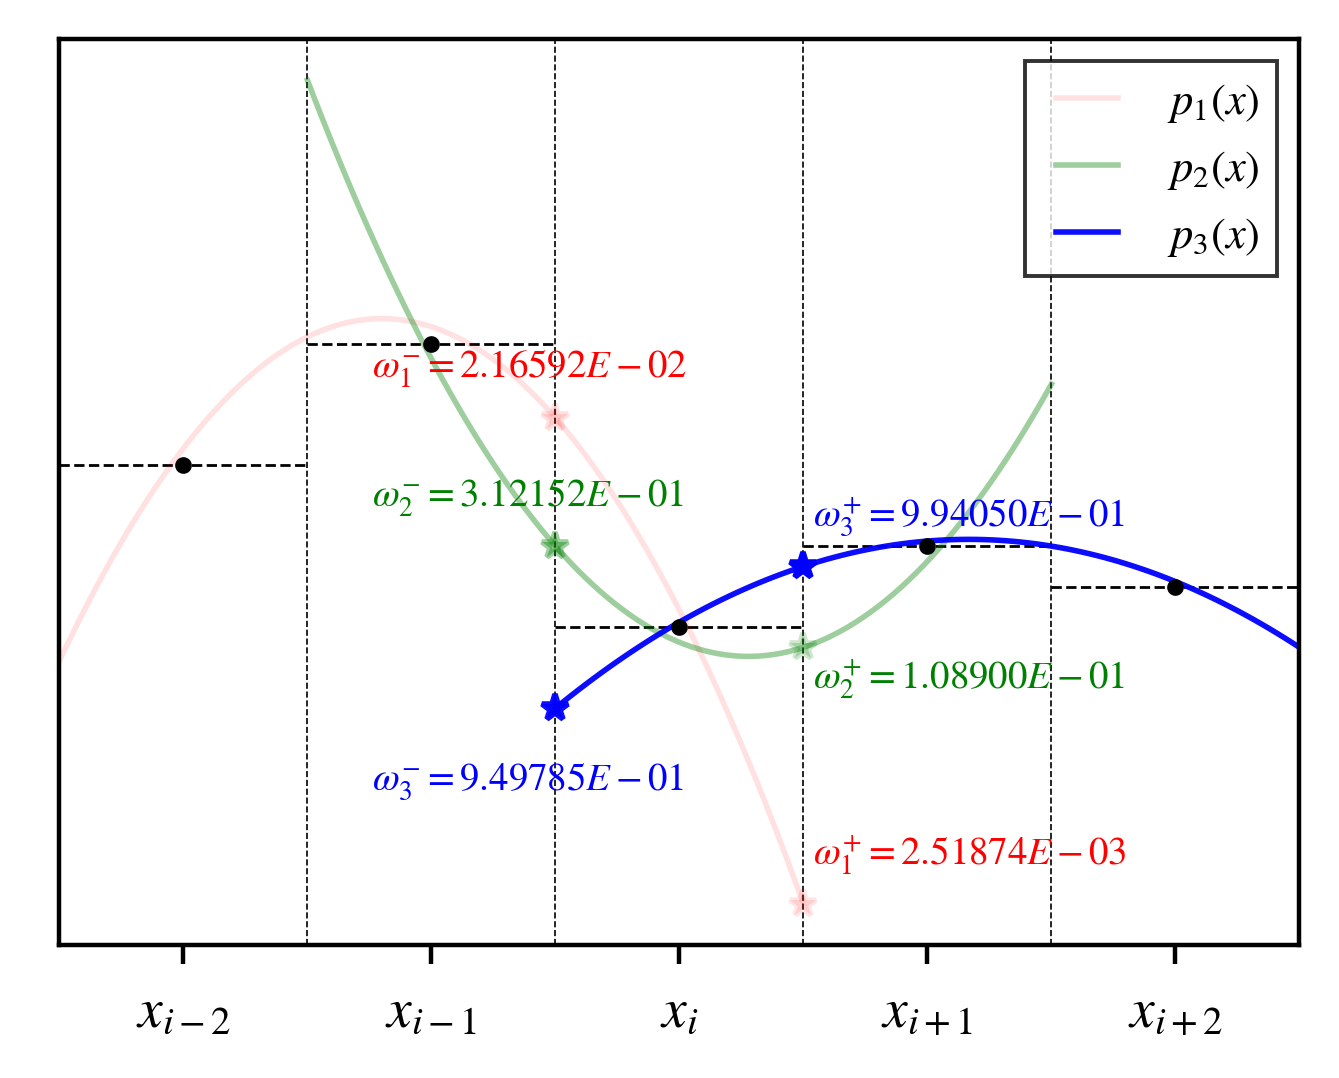

In [8]:
############ smooth profile?
#################################
########## this is not used (yet) ##########

s = np.array([9, 12, 5, 7, 6])



fig = plt.figure(figsize=(4,3), dpi=400)
ax = fig.add_subplot(1,1,1)

# vertical lines at cell interfaces
for interface in cell_interfaces:
    ax.axvline(x=interface, color='k', linestyle='--', linewidth=0.3)

# horizontal lines at cell centers
for idx, point in enumerate(s):
    ax.axhline(point, xmin=idx*0.2, xmax=(idx+1)*0.2, color='k', linestyle='--', linewidth=0.5)

ax.set_xlim((cell_interfaces[0], cell_interfaces[-1]))
ax.set_xticks(x)
ax.set_xticklabels(cell_names)

# ax.set_ylim((0,s.max()*1.4))

ax.set_yticks([])


ximh = cell_interfaces[2]
xiph = cell_interfaces[3]

# reconstructions
omega_imh = nonlin_weights(s, 'imh')
omega_iph = nonlin_weights(s, 'iph')

opac_imh = 0.1 + 0.9*omega_imh
opac_iph = 0.1 + 0.9*omega_iph

# phi
# poly = recon(x, s)
# xx = np.linspace(cell_interfaces[0], cell_interfaces[-1], 100)
# ax.plot(xx, poly(xx), 'm-', linewidth=1, label='$\phi(x)$')
# ax.plot(ximh, poly(ximh), 'm*', markersize=5)

#p1
poly1 = recon(x[:3], s[:3])
xx = np.linspace(cell_interfaces[0], cell_interfaces[3], 100)
ax.plot(xx, poly1(xx), 'r-', linewidth=1, label='$p_{1}(x)$', alpha=opac_imh[0])
ax.plot(ximh, poly1(ximh), 'r*', markersize=5, alpha=opac_imh[0])
ax.plot(xiph, poly1(xiph), 'r*', markersize=5, alpha=opac_iph[0])

# ax.plot(ximh, poly1(ximh), 'ro', fillstyle='none', markersize=10)


#p2
poly2 = recon(x[1:4], s[1:4])
xx = np.linspace(cell_interfaces[1], cell_interfaces[4], 100)
ax.plot(xx, poly2(xx), 'g-', linewidth=1, label='$p_{2}(x)$', alpha=opac_imh[1])
ax.plot(ximh, poly2(ximh), 'g*', markersize=5, alpha=opac_imh[1])
ax.plot(xiph, poly2(xiph), 'g*', markersize=5, alpha=opac_iph[1])
#p3
poly3 = recon(x[2:], s[2:])
xx = np.linspace(cell_interfaces[2], cell_interfaces[-1], 100)
ax.plot(xx, poly3(xx), 'b-', linewidth=1, label='$p_{3}(x)$', alpha=opac_imh[2])
ax.plot(ximh, poly3(ximh), 'b*', markersize=5, alpha=opac_imh[2])
ax.plot(xiph, poly3(xiph), 'b*', markersize=5, alpha=opac_iph[2])

ax.plot(x, s, 'ko', markersize=2)


ax.text(ximh-.74, poly1(ximh)+1, '$\omega_{{1}}^{{-}} = {0:.5E}$'.format(omega_imh[0]), size=7, color='r')
ax.text(ximh-.74, poly2(ximh)+1, '$\omega_{{2}}^{{-}} = {0:.5E}$'.format(omega_imh[1]), size=7, color='g')
ax.text(ximh-.74, poly3(ximh)-2, '$\omega_{{3}}^{{-}} = {0:.5E}$'.format(omega_imh[2]), size=7, color='b')

ax.text(xiph+.04, poly1(xiph)+1, '$\omega_{{1}}^{{+}} = {0:.5E}$'.format(omega_iph[0]), size=7, color='r')
ax.text(xiph+.04, poly2(xiph)-1, '$\omega_{{2}}^{{+}} = {0:.5E}$'.format(omega_iph[1]), size=7, color='g')
ax.text(xiph+.04, poly3(xiph)+1, '$\omega_{{3}}^{{+}} = {0:.5E}$'.format(omega_iph[2]), size=7, color='b')

legend = ax.legend(loc='upper right')
legend.get_frame().set_linewidth(.7)

# fig.savefig('weno_p1p2p3_nonlinW_smooth.pdf', bbox_inches='tight', pad_inches=0.05)